# ML Pipeline Workflow
# 


The following workflow will be executed in this notebook:
1. Import common libraries for machine learning pipelines
2. Load the dataset
3. Create a Customer Text Transformer
4. Build a machine learning pipeline
5. Test model performance - 1st iteration
6. Hyperparameter tuning: Improve Model Performance
7. Test model performance - 2nd iteration
8. Train on best hyperparameters
9. Compare Training Results 
10. Improve Model Performance: Train another classifer
11. Final Comparison of all Models - 3rd iteration
12. Export the model as a pickle file





### 1. Import Required Libraries

In [1]:
# import libraries
import re # for regular expressions
import numpy as np # numeric python, vector operations
import pandas as pd # data manipulation
from nltk.corpus import stopwords # natural language tool kit: stopwords
from nltk.tokenize import word_tokenize # natural language tool kit: word_tokenize
from nltk.stem import WordNetLemmatizer # natural language tool kit: lemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # for text processing
from sklearn.model_selection import train_test_split # for splitting data into training and testing
from sklearn.multioutput import MultiOutputClassifier   # for multi-output classification
from sklearn.ensemble import RandomForestClassifier # for random forest classifier
from sklearn.pipeline import Pipeline   # for creating a pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score # for model evaluation

import warnings 
warnings.filterwarnings('ignore')

###  2. Load the dataset
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# load data from database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///../data/disaster_response.db')
df = pd.read_sql_table('features', engine) 
X = df['message']
y = df.iloc[:,4:]

### 3. Create a Customer Text Transformer

In [3]:
# create custom text transformer

def tokenize(text):
    """
    This function takes a text and returns a list of cleaned and tokenized words.
    Designed to be used in a pipeline, with the CountVectorizer and TfidfTransformer objects

    Args:
    text: str: a string of text to be tokenized

    Returns:
    lemmed: list: a list of cleaned and tokenized words
    """
    # Normalize text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Tokenize text
    words = word_tokenize(text)
    
    # Remove stop words
    words = [w for w in words if w not in stopwords.words("english")]
    
    # Lemmatization
    words = [WordNetLemmatizer().lemmatize(w) for w in words]

    # Stemming (not used, does not improve performance)
    # stemmed = [PorterStemmer().stem(w) for w in lemmed]
    
    return words
    

### Test Tokenization Function

In [4]:
# test out function
for message in X.sample(5):
    tokens = tokenize(message)
    print(message)
    print(tokens, '\n')

The earthquake was violent enough to move Concepcion 10feet to the west and Santiago 11inches to the west-southwest http://bit.ly/9oNfHA
['earthquake', 'violent', 'enough', 'move', 'concepcion', '10feet', 'west', 'santiago', '11inches', 'west', 'southwest', 'http', 'bit', 'ly', '9onfha'] 

Government officials are extremely concerned that swarms of the voracious insects may cause heavy damage to country's cashew nut trees, which are currently in flower.
['government', 'official', 'extremely', 'concerned', 'swarm', 'voracious', 'insect', 'may', 'cause', 'heavy', 'damage', 'country', 'cashew', 'nut', 'tree', 'currently', 'flower'] 

However, the nature and characteristics of crises continued to change amid challenges posed by organized crime, illegal trade in small arms and light weapons, human and drug trafficking and maritime piracy.
['however', 'nature', 'characteristic', 'crisis', 'continued', 'change', 'amid', 'challenge', 'posed', 'organized', 'crime', 'illegal', 'trade', 'small', 

### 4. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
# Pipeline will have 3 steps
# 1. CountVectorizer - Convert a collection of text documents to a matrix of token counts
# 2. TfidfTransformer - Transform a count matrix to a normalized tf or tf-idf representation
# 3. MultiOutputClassifier - This is a simple meta-estimator for fitting one classifier per target.
pipeline = Pipeline([ 
    ('vect', CountVectorizer(tokenizer=tokenize)), # here is where you use the custom text transformer
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(verbose=1)))
])

### Train pipeline with the Benchmark model (we will look to improve through more iterations)
- Split data into train and test sets
- Train pipeline

In [6]:
# show params for benchmark model
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x165ef4180>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier(verbose=1)))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x165ef4180>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(verbose=1)),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': Fal

In [7]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# show shape of the different datsets
print(f'total training observations: {X_train.shape[0]}')
print(f'total testing observations: {X_test.shape[0]}')

total training observations: 20972
total testing observations: 5244


In [8]:
# train classifier
pipeline.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    9.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Do

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x165ef4180>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(verbose=1)))])

### 5. Test your model - 1st iteration
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

### Create reusable function to evaluate model performance for all 36 classes

In [9]:
def extract_precision(df,iteration):
    """
    Extract the precision from the results dataframe and annotates columns for comparison

    Args:
    df: DataFrame: the results dataframe
    iteration: int: the iteration number

    Returns:
    DataFrame: a dataframe containing the precision and support metrics
    """
    # filter the results to only include the precision and support metrics
    df = df.loc[df.metric=='1',['label','precision']].reset_index(drop=True)

    # add _iteration to the column names, starting with column 1
    df.columns = ['label', f'precision_{iteration}']

    return df


def evaluate_models(X_test,y_test,estimator,iteration):
    """
        Evaluate the model by calculating the precision, recall, and f1-score for each label
    
        Args:
        X_test: the test features
        y_test: the test labels
        estimator: the trained model
    
        Returns:
        results: a dataframe containing the precision, recall, and f1-score for each label
    """
    # import report that captures appropriate metrics
    from sklearn.metrics import classification_report

    # predict on test data
    y_pred = estimator.predict(X_test)

    # initialize an empty dataframe to store the results
    results = pd.DataFrame()

    # calculate and store the precision, recall, and f1-score for each label
    for i, col in enumerate(y_test.columns):
        report = classification_report(y_test[col], y_pred[:, i], output_dict=True)
        df = pd.DataFrame(report).transpose()
        df['label'] = col
        results = pd.concat([results, df])

    # reset the index of the results dataframe
    results.reset_index(inplace=True)
    results.rename(columns={'index': 'metric'}, inplace=True)

    # rearrange the columns to put 'label' first
    cols = ['label'] + [col for col in results.columns if col != 'label']
    results = results[cols]

    # round the results to 2 decimal places
    results = results.round(2)

    # convert the 'support' column to integers
    results.support = results.support.astype(int)

    # extract the precision from the results dataframe
    results = extract_precision(results,iteration)
    
    return results



In [10]:
# evaluate the model, 1st iteration
results1 = evaluate_models(X_test,y_test,pipeline,1)

results1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

,label,precision_1
0,related,0.84
1,request,0.87
2,offer,0.00
3,aid_related,0.75
4,medical_help,0.55
5,medical_products,0.78
6,search_and_rescue,0.80
7,security,0.50
8,military,0.59
9,water,0.90


### 6. Improve your model
Use grid search to find better parameters. 

In [11]:
# use grid search to find better parameters
from sklearn.model_selection import GridSearchCV

# pipeline
pipeline = Pipeline([ 
    ('vect', CountVectorizer(tokenizer=tokenize)), # here is where you use the custom text transformer
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(verbose=1)))
])

# we are limiting the grid to these options, which will take 2 hrs to train
# adding parameters will increase time exponentially
parameters = {
    'clf__estimator__n_estimators':[5, 10],
    'clf__estimator__max_depth': [3, 5],
    'clf__estimator__min_samples_split': [2, 4]
}

# instantiate grid search object with appropriate parameters
cv = GridSearchCV(pipeline, 
                  param_grid=parameters, 
                  verbose=1, 
                  cv=5, 
                  n_jobs=1, 
                  return_train_score=True, 
                  scoring='f1_weighted')

# train the model
cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x165ef4180>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(verbose=1)))]),
             n_jobs=1,
             param_grid={'clf__estimator__max_depth': [3, 5],
                         'clf__estimator__min_samples_split': [2, 4],
                         'clf__estimator__n_estimators': [5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=1)

### 7. Test your model - 2nd iteration
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [12]:
# evaluate the model - 2nd iteration    
results2 = evaluate_models(X_test,y_test,cv,2)

results2


,label,precision_2
0,related,0.76
1,request,0.00
2,offer,0.00
3,aid_related,0.89
4,medical_help,0.00
5,medical_products,0.00
6,search_and_rescue,0.00
7,security,0.00
8,military,0.00
9,water,0.00


In [13]:
# show the best parameters
print('best parameters:', cv.best_params_)

best parameters: {'clf__estimator__max_depth': 3, 'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 5}


### 8. Train the model on the best parameters and evaluate performance

In [14]:
# build pipeline
pipeline = Pipeline([ 
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(verbose=1)))
])

# set pareters to best parameters from grid search
pipeline.set_params(**cv.best_params_)

# fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x165ef4180>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=3,
                                                                        n_estimators=5,
                                                                        verbose=1)))])

In [15]:
# evaluate the model - 3rd iteration
results3 = evaluate_models(X_test,y_test,pipeline,3)

results3

,label,precision_3
0,related,0.76
1,request,0.00
2,offer,0.00
3,aid_related,0.74
4,medical_help,0.00
5,medical_products,0.00
6,search_and_rescue,0.00
7,security,0.00
8,military,0.57
9,water,0.00


### 9. Compare training results with the benchmark model
The second model is clearly not catching the true positive classes<br>
We will attempt to train on a different classifer to see if we can improve accuracy<br>
<br>
Now we will look closer at the different model results

In [16]:
# consolidate results between 3 models

# import reduce, which is used to combine the dataframes
from functools import reduce

# combine the precision dataframes
dfs = [results1, results2, results3]

# merge the dataframes on the 'label' column
results = reduce(lambda left, right: pd.merge(left, right, on='label'), dfs)

results

,label,precision_1,precision_2,precision_3
0,related,0.84,0.76,0.76
1,request,0.87,0.00,0.00
2,offer,0.00,0.00,0.00
3,aid_related,0.75,0.89,0.74
4,medical_help,0.55,0.00,0.00
5,medical_products,0.78,0.00,0.00
6,search_and_rescue,0.80,0.00,0.00
7,security,0.50,0.00,0.00
8,military,0.59,0.00,0.57
9,water,0.90,0.00,0.00


### 10.  Improve Model Performance: Train another classifer
We will attempt to train the same pipline with an XGboost Classifier

In [17]:
# use the XGBoost classifier for multiclass objective function
from xgboost import XGBClassifier

# create a pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(XGBClassifier()))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x165ef4180>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metr...
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...)))])

In [18]:
# evaluate the model
results4 = evaluate_models(X_test, y_test, pipeline,4)

results4

,label,precision_4
0,related,0.82
1,request,0.80
2,offer,0.00
3,aid_related,0.77
4,medical_help,0.58
5,medical_products,0.68
6,search_and_rescue,0.61
7,security,0.00
8,military,0.56
9,water,0.77


### 11.  Final Comparison of all Models - 3rd iteration


In [19]:
# merge the results with other iterations
results = pd.merge(results, results4, on='label', how='left')

# rename columns
results.columns = ['label', 'random_forest_1', 'random_forest_2', 'random_forest_3', 'xgboost']

# add the column with the highest value as the value for best model
results['best_model'] = results.iloc[:,1:].idxmax(axis=1)


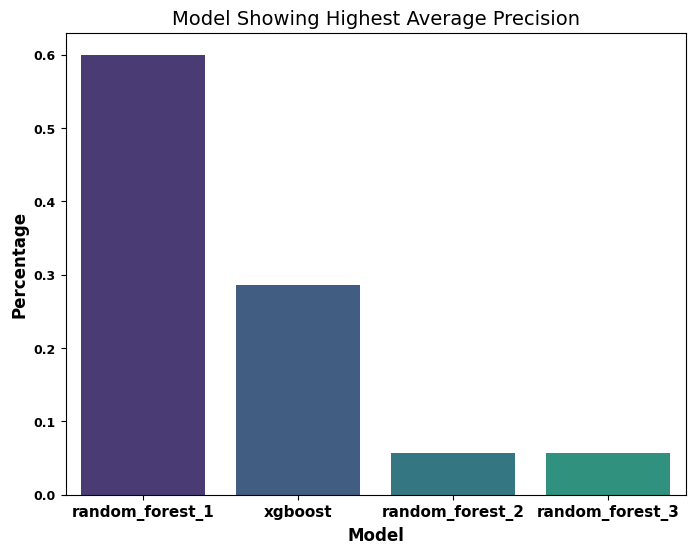

In [47]:
from matplotlib import pyplot as plt
import seaborn as sns

# set rc parameters, font weight and size
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 9


plot_best_model = results.best_model.value_counts(normalize=True)

palette = sns.color_palette("viridis", as_cmap=False)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=plot_best_model.index, y=plot_best_model.values, ax=ax, palette=palette)
ax.set_title('Model Showing Highest Average Precision')
ax.set_ylabel('Percentage')
ax.set_xlabel('Model')
plt.show()


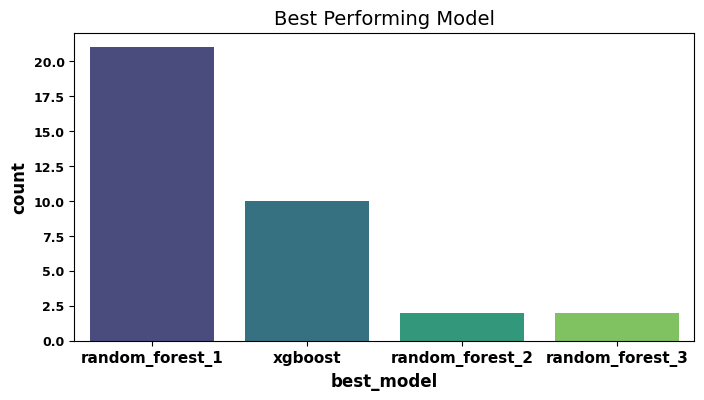

In [48]:
from matplotlib import pyplot as plt
import seaborn as sns

# show value counts of the best performing model
fig, ax  = plt.subplots(figsize=(8,4))
sns.countplot(data=results, x='best_model', ax=ax, order=results.best_model.value_counts(normalize=True).index, palette='viridis')
plt.title('Best Performing Model')
plt.show()

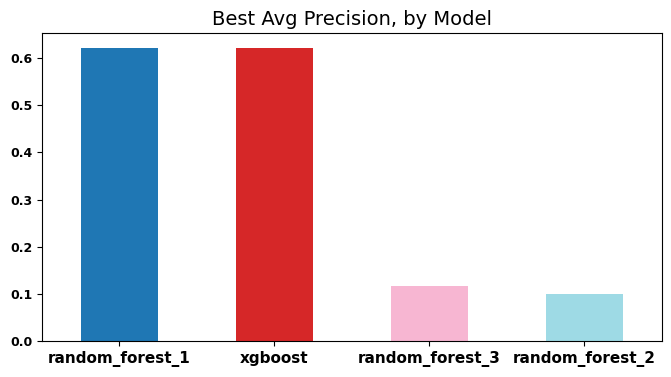

In [68]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# create a colormap
cmap = cm.get_cmap('tab20')  # get the 'viridis' colormap
colors = cmap(np.linspace(0, 1, len(results.columns[1:5])))  # create a list of colors from the colormap

# plot the best models
best_models = (
                results.agg({col:'mean' for col in results.columns[1:5]})
                       .sort_values(ascending=False)
                       .plot(kind='bar', 
                             figsize=(8,4),
                             title='Best Avg Precision, by Model',
                             color=colors  # use the colors from the colormap
                             )
              ) 

plt.xticks(rotation=0, ha='center')  # adjust the x labels
plt.show()

### Summary of Model Training Iterations
1.  Benchmark model: RandomForestClassifier - showed 95% accuracy
2.  Grid Search: We tried 4 different sets of hyperparameters with cross validation.  However, the model seriously underfit and could not detect most of the postive classes.
3.  XGBoost - We tried XGBoost with GridSearch and it showed 95% accuracy.  We saved this model as the final model.

### 12. Export your model as a pickle file

In [22]:
# export your model as a pickel file
import joblib
with open('classifier.pkl', 'wb') as file:
    joblib.dump(pipeline, file, compress=5)

# load model


### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.